In [12]:
import os
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.xception import  Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import  ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import keras.callbacks as kcallbacks
import keras

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
#from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import image_utils


import math
import random
from keras.utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [13]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)        #输入大小设为（224,224,3）
BATCHSIZE=128	#could try 128 or 32  #批量大小设置为128

#Normalization
#ImageDataGenerator，rescale的作用是对图片的每个像素值均乘上这个放缩因子，这个操作在所有其它变换操作之前执行，在一些模型当中，
#直接输入原图的像素值可能会落入激活函数的“死亡区”，因此设置放缩因子为1/255，把像素值放缩到0和1之间有利于模型的收敛，避免神经元“死亡”。
train_datagen = ImageDataGenerator(rescale=1./255)  ##归一化

test_datagen = ImageDataGenerator(rescale=1./255)   # #不增强验证数据

train_generator = train_datagen.flow_from_directory(  #从指定的目录中生成训练图像
        './dataset/train_224',##训练文件路径--文件夹下多分类文件夹
        target_size=TARGET_SIZE,                     #目标大小设置为(224,224)，图像统一尺寸
        batch_size=BATCHSIZE,                        #batch数据的大小,默认32
        class_mode='categorical')                   #返回标签数组形式 'binary'二进制；
validation_generator = test_datagen.flow_from_directory(  #从指定的目录中生成测试图像
        './dataset/test_224',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 4313 images belonging to 5 classes.
Found 1024 images belonging to 5 classes.


In [14]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch': [], 'epoch': []}
        self.accuracy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_acc = {'batch': [], 'epoch': []}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_accuracy'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        #创建一个图
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')#plt.plot(x,y)，这个将数据画成曲线
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)#设置网格形式
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')#给x，y轴加注释
        plt.legend(loc="upper right")#设置图例显示位置
        plt.savefig('acc-loss.jpg', dpi=800)
        plt.show()

In [15]:
#创建一个LossHistory的实例
history_this= LossHistory()

In [136]:
def cnn_by_own(input_shape,num_class,epochs,savepath='./dataset/model_own.h5'):
    model = Sequential()
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=input_shape,padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc', patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
    #verbose:日志的显示模式，取 1 时表示“进度条模式”，取2时表示“每轮一行”，取0时表示“安静模式”；
    hist=model.fit_generator(
        train_generator,#generator：指需要训练的训练集
        steps_per_epoch=len(train_generator), #steps_per_epochs:是指在每个epoch中生成器执行生成数据的次数
        epochs=epochs,
        validation_data=validation_generator, #validation_data：验证集
        validation_steps=len(validation_generator),#当validation_data为生成器时，本参数指定验证集的生成器返回次数，validation_steps：指验证集的情况，类似于steps_per_epoch
        callbacks=[history_this],
    )
    model.save('my_model.h5')
    model = load_model('my_model.h5')

Epoch 1/20
34/34 [==============================] - 15s 346ms/step - loss: 1.3118 - accuracy: 0.4164 - val_loss: 0.9774 - val_accuracy: 0.5215
Epoch 2/20
34/34 [==============================] - 11s 333ms/step - loss: 0.7796 - accuracy: 0.6555 - val_loss: 0.3875 - val_accuracy: 0.8799
Epoch 3/20
34/34 [==============================] - 12s 341ms/step - loss: 0.3781 - accuracy: 0.8653 - val_loss: 0.3231 - val_accuracy: 0.8799
Epoch 4/20
34/34 [==============================] - 11s 327ms/step - loss: 0.1444 - accuracy: 0.9467 - val_loss: 0.0198 - val_accuracy: 0.9932
Epoch 5/20
34/34 [==============================] - 12s 356ms/step - loss: 0.0560 - accuracy: 0.9815 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 6/20
34/34 [==============================] - 11s 323ms/step - loss: 0.0122 - accuracy: 0.9963 - val_loss: 0.0118 - val_accuracy: 0.9951
Epoch 7/20
34/34 [==============================] - 11s 328ms/step - loss: 0.0097 - accuracy: 0.9958 - val_loss: 0.0010 - val_accuracy: 1.0000

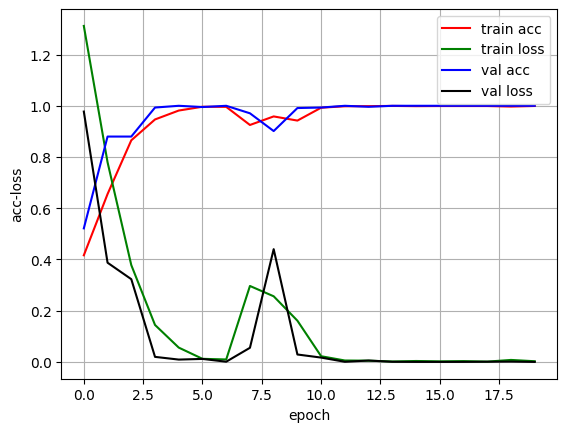

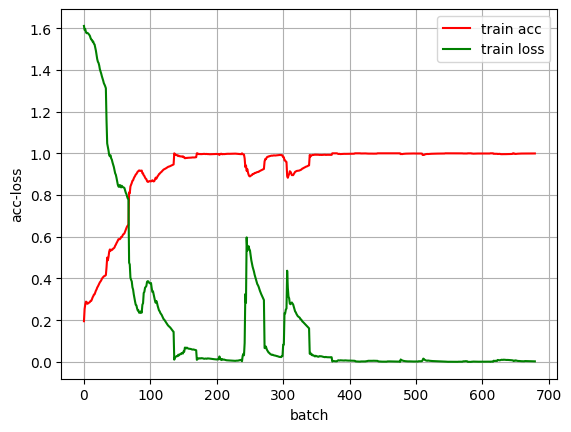

In [137]:
cnn_by_own(input_shape=INPUT_SIZE,num_class=5,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

VGG16

In [23]:
#Hyperopt estimated optimum {'dropout_rate': 0.5, 'epochs': 20.0, 'frozen': 16.0, 'lr': 0.004, 
#'patience': 3.0}
#Time: 1372.7469055652618
def vgg16(num_class,epochs,savepath='./VGG16.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:16]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[16:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output) #GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )
    model.save('VGG16.h5')
    model = load_model('VGG16.h5')

58889256/58889256 [==============================] - 6s 0us/step


/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_20130/2497238611.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.4278 - accuracy: 0.6223
Epoch 1: val_accuracy improved from -inf to 0.90137, saving model to ./VGG16.h5
34/34 [==============================] - 14s 358ms/step - loss: 2.4278 - accuracy: 0.6223 - val_loss: 0.1357 - val_accuracy: 0.9014
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9666
Epoch 2: val_accuracy improved from 0.90137 to 0.99609, saving model to ./VGG16.h5
34/34 [==============================] - 11s 328ms/step - loss: 0.0754 - accuracy: 0.9666 - val_loss: 0.0082 - val_accuracy: 0.9961
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9963
Epoch 3: val_accuracy improved from 0.99609 to 0.99707, saving model to ./VGG16.h5
34/34 [==============================] - 11s 327ms/step - loss: 0.0111 - accuracy: 0.9963 - val_loss: 0.0081 - val_accuracy: 0.9971
Epoch 4/20
34/34 [==============================] - ETA: 0s - loss: 0.0155 -

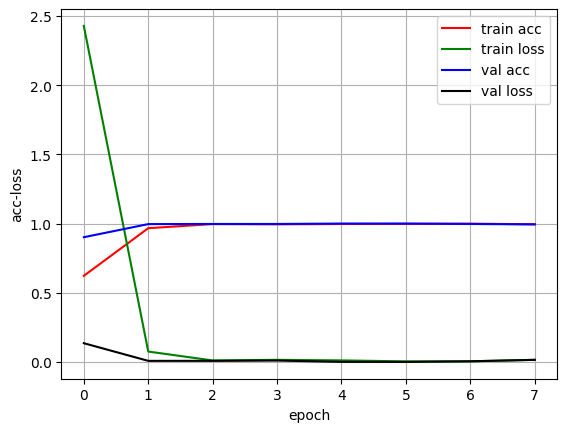

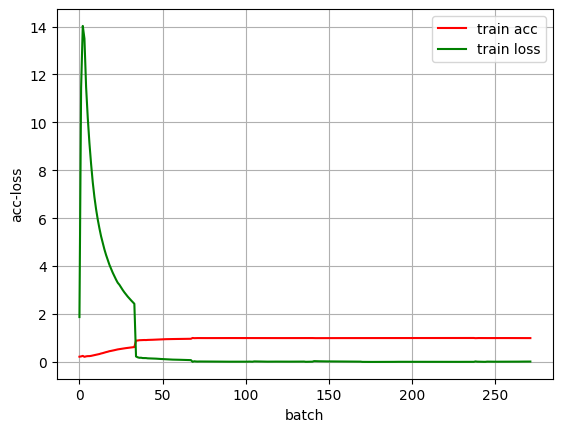

In [24]:
vgg16(num_class=5,epochs=20)	#tf36cnn
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [ ]:
#Resnet

In [145]:
#Hyperopt estimated optimum {'dropout_rate': 0.6000000000000001, 'epochs': 25.0, 
#'frozen': 135.0, 'lr': 4e-06, 'patience': 4.0}
#Time: 2884.955158472061
def resnet( num_class, epochs,savepath='./resnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:135]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[135:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.6)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=4e-06, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=4, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/25
34/34 [==============================] - 14s 336ms/step - loss: 0.6845 - accuracy: 0.7883 - val_loss: 1.9586 - val_accuracy: 0.0996
Epoch 2/25
34/34 [==============================] - 10s 304ms/step - loss: 0.1921 - accuracy: 0.9592 - val_loss: 1.8815 - val_accuracy: 0.2998
Epoch 3/25
34/34 [==============================] - 10s 306ms/step - loss: 0.1146 - accuracy: 0.9782 - val_loss: 1.8325 - val_accuracy: 0.3037
Epoch 4/25
34/34 [==============================] - 10s 303ms/step - loss: 0.0794 - accuracy: 0.9838 - val_loss: 1.7477 - val_accuracy: 0.3506
Epoch 5/25
34/34 [==============================] - 10s 306ms/step - loss: 0.0576 - accuracy: 0.9886 - val_loss: 1.5417 - val_accuracy: 0.3701
Epoch 6/25
34/34 [==============================] - 10s 306ms/step - loss: 0.0401 - accuracy: 0.9944 - val_loss: 1.2515 - val_accuracy: 0.4102
Epoch 7/25
34/34 [==============================] - 10s 303ms/step - loss: 0.0333 - accuracy: 0.9954 - val_loss: 0.8834 - val_accuracy: 0.5469

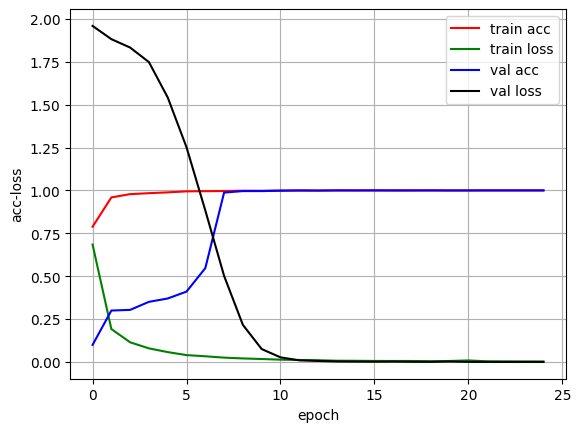

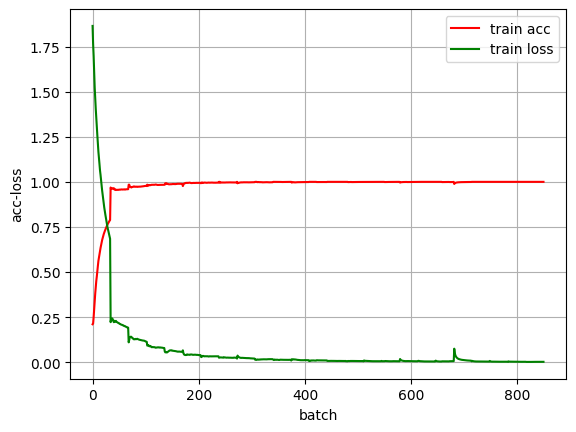

In [146]:
resnet(num_class=5,epochs=25)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [ ]:
#inception-v3

In [27]:
#Hyperopt estimated optimum {'dropout_rate': 0.6000000000000001, 
#'epochs': 25.0, 'frozen': 34.0, 'lr': 4e-06, 'patience': 3.0}
#Time: 1529.8161406517029
def inception(num_class,epochs,savepath='./inception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:34]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[34:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.6)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='inception')
    opt = keras.optimizers.Adam(lr=4e-06, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #callbacks=[earlyStopping, saveBestModel, history],
        callbacks=[saveBestModel, history]
    )
    model.save('inception.h5')
    model = load_model('inception.h5')

87910968/87910968 [==============================] - 4s 0us/step


/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_20130/2030134478.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.3664 - accuracy: 0.4489
Epoch 1: val_accuracy improved from -inf to 0.46191, saving model to ./inception.h5
34/34 [==============================] - 19s 380ms/step - loss: 1.3664 - accuracy: 0.4489 - val_loss: 1.6593 - val_accuracy: 0.4619
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.7327 - accuracy: 0.7948
Epoch 2: val_accuracy improved from 0.46191 to 0.48047, saving model to ./inception.h5
34/34 [==============================] - 11s 329ms/step - loss: 0.7327 - accuracy: 0.7948 - val_loss: 1.4226 - val_accuracy: 0.4805
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.8996
Epoch 3: val_accuracy improved from 0.48047 to 0.50000, saving model to ./inception.h5
34/34 [==============================] - 11s 337ms/step - loss: 0.4660 - accuracy: 0.8996 - val_loss: 1.1281 - val_accuracy: 0.5000
Epoch 4/25
34/34 [==============================] - ETA: 0s - lo

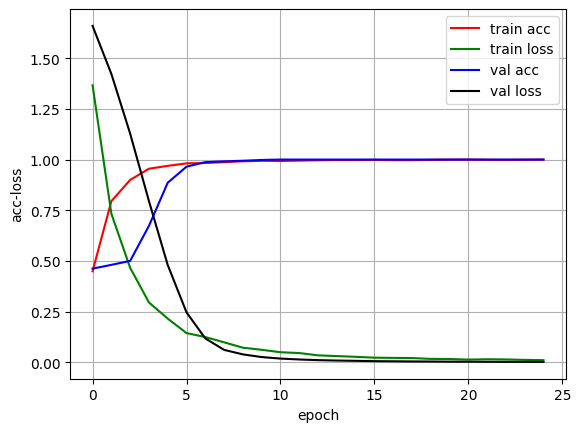

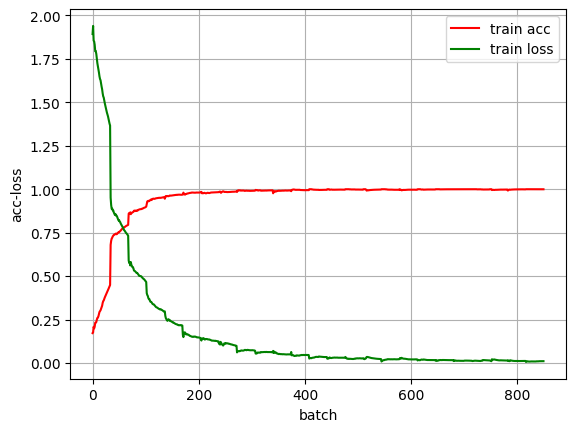

In [28]:
inception(num_class=5,epochs=25)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [7]:
import keras

print(keras.__version__)


2.11.0


#接下来记性测试了

In [32]:
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD
import operator
import numpy as np
from PIL import Image
from collections import defaultdict

In [34]:
#generate images from train set and validation set
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128

test_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = test_datagen.flow_from_directory(
        './dataset/test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 1024 images belonging to 5 classes.


In [35]:
#generate labels indicating disease (1) or normal (0)
label=validation_generator.class_indices
label={v: k for k, v in label.items()}

In [53]:
#read images from validation folder
rootdir = './dataset/test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

4 ./dataset/test_224/4/24381.png


In [39]:
print(label)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}


In [59]:
 #load model 1: VGG16
vgg16_model=load_model('./VGG16.h5')

In [57]:
 #load model 2: inception
inception_model=load_model('./inception.h5')

In [147]:
 #load model 3: resnet
resnet_model=load_model('./resnet.h5')

In [140]:
 #load model 3: my_model
my_model_model=load_model('./my_model.h5')

In [45]:
!pip install opencv-python

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 221.3 MB/s eta 0:00:00a 0:00:01


1/1 [==============================] - 0s 155ms/step
Predicted result for the first image: 0
Confidence level: 0.9999871


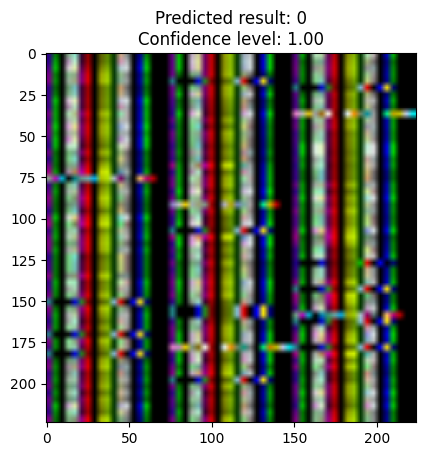

In [97]:
import cv2
import matplotlib.pyplot as plt

test = cv2.imread(test_images[800])
img_show = test[:, :, [2, 1, 0]]
test = test / 255.
test_shape = (1,) + test.shape
test = test.reshape(test_shape)

res = vgg16_model.predict(test)

prob = res[0, np.argmax(res, axis=1)[0]]
res = label[np.argmax(res, axis=1)[0]]
print('Predicted result for the first image: %s' % res)
print('Confidence level: %s' % prob)

# Save the image with the prediction and confidence level
plt.imshow(img_show)
plt.title('Predicted result: ' + res + '\n' + 'Confidence level: {:.2f}'.format(prob))
plt.savefig('predicted_image4.png')  # Save the figure as a PNG image
plt.show()

1/1 [==============================] - 0s 26ms/step
Predicted result for the first image: 2
Confidence level: 0.9613257


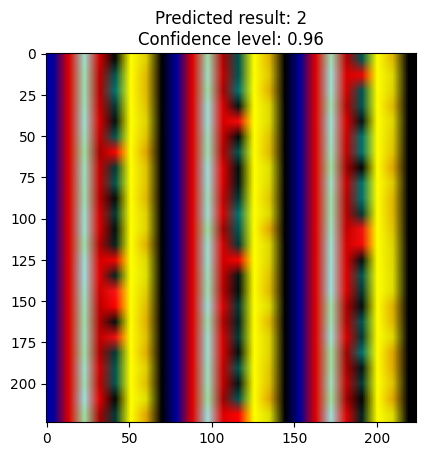

In [125]:
import cv2
import matplotlib.pyplot as plt

test = cv2.imread(test_images[101])
img_show = test[:, :, [2, 1, 0]]
test = test / 255.
test_shape = (1,) + test.shape
test = test.reshape(test_shape)

res = vgg16_model.predict(test)

prob = res[0, np.argmax(res, axis=1)[0]]
res = label[np.argmax(res, axis=1)[0]]
print('Predicted result for the first image: %s' % res)
print('Confidence level: %s' % prob)

# Save the image with the prediction and confidence level
plt.imshow(img_show)
plt.title('Predicted result: ' + res + '\n' + 'Confidence level: {:.2f}'.format(prob))
plt.savefig('predicted_image9.png')  # Save the figure as a PNG image
plt.show()

1/1 [==============================] - 0s 26ms/step
Predicted result for the first image: 2
Confidence level: 1.0


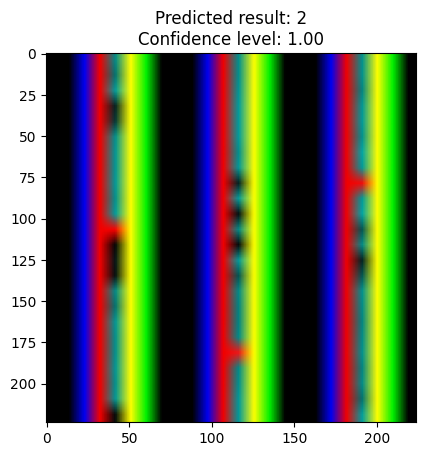

In [124]:
import cv2
import matplotlib.pyplot as plt

test = cv2.imread(test_images[500])
img_show = test[:, :, [2, 1, 0]]
test = test / 255.
test_shape = (1,) + test.shape
test = test.reshape(test_shape)

res = vgg16_model.predict(test)

prob = res[0, np.argmax(res, axis=1)[0]]
res = label[np.argmax(res, axis=1)[0]]
print('Predicted result for the first image: %s' % res)
print('Confidence level: %s' % prob)

# Save the image with the prediction and confidence level
plt.imshow(img_show)
plt.title('Predicted result: ' + res + '\n' + 'Confidence level: {:.2f}'.format(prob))
plt.savefig('predicted_image5.png')  # Save the figure as a PNG image
plt.show()

1/1 [==============================] - 0s 36ms/step
Predicted result for the first image: 2
Confidence level: 1.0


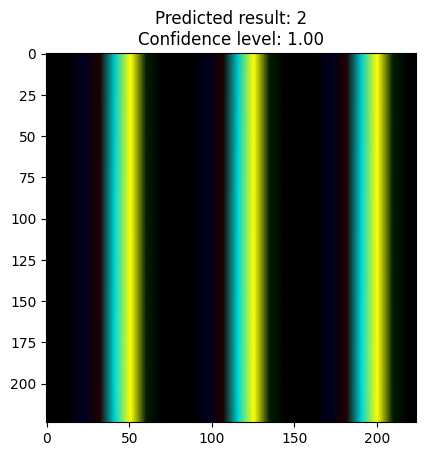

In [99]:
import cv2
import matplotlib.pyplot as plt

test = cv2.imread(test_images[600])
img_show = test[:, :, [2, 1, 0]]
test = test / 255.
test_shape = (1,) + test.shape
test = test.reshape(test_shape)

res = vgg16_model.predict(test)

prob = res[0, np.argmax(res, axis=1)[0]]
res = label[np.argmax(res, axis=1)[0]]
print('Predicted result for the first image: %s' % res)
print('Confidence level: %s' % prob)

# Save the image with the prediction and confidence level
plt.imshow(img_show)
plt.title('Predicted result: ' + res + '\n' + 'Confidence level: {:.2f}'.format(prob))
plt.savefig('predicted_image6.png')  # Save the figure as a PNG image
plt.show()

1/1 [==============================] - 0s 26ms/step
Predicted result for the first image: 0
Confidence level: 1.0


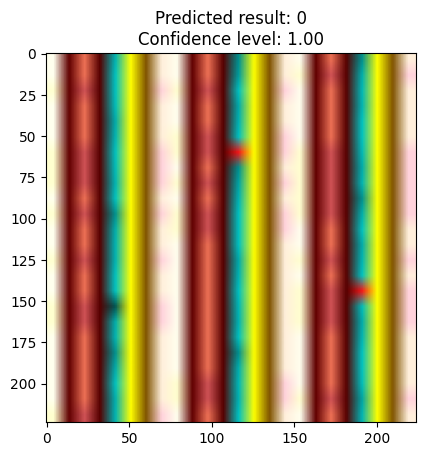

In [100]:
import cv2
import matplotlib.pyplot as plt

test = cv2.imread(test_images[900])
img_show = test[:, :, [2, 1, 0]]
test = test / 255.
test_shape = (1,) + test.shape
test = test.reshape(test_shape)

res = vgg16_model.predict(test)

prob = res[0, np.argmax(res, axis=1)[0]]
res = label[np.argmax(res, axis=1)[0]]
print('Predicted result for the first image: %s' % res)
print('Confidence level: %s' % prob)

# Save the image with the prediction and confidence level
plt.imshow(img_show)
plt.title('Predicted result: ' + res + '\n' + 'Confidence level: {:.2f}'.format(prob))
plt.savefig('predicted_image7.png')  # Save the figure as a PNG image
plt.show()

1/1 [==============================] - 0s 27ms/step
Predicted result for the first image: 3
Confidence level: 0.99999976


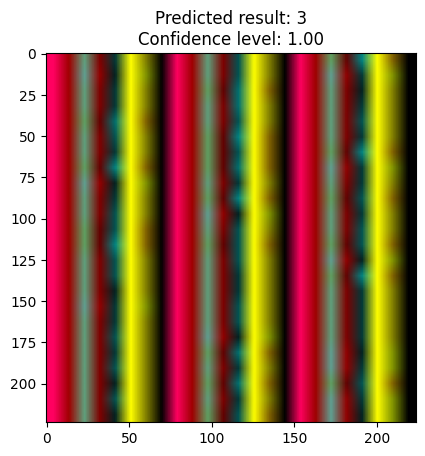

In [109]:
import cv2
import matplotlib.pyplot as plt

test = cv2.imread(test_images[399])
img_show = test[:, :, [2, 1, 0]]
test = test / 255.
test_shape = (1,) + test.shape
test = test.reshape(test_shape)

res = vgg16_model.predict(test)

prob = res[0, np.argmax(res, axis=1)[0]]
res = label[np.argmax(res, axis=1)[0]]
print('Predicted result for the first image: %s' % res)
print('Confidence level: %s' % prob)

# Save the image with the prediction and confidence level
plt.imshow(img_show)
plt.title('Predicted result: ' + res + '\n' + 'Confidence level: {:.2f}'.format(prob))
plt.savefig('predicted_image8.png')  # Save the figure as a PNG image
plt.show()

1/1 [==============================] - 0s 72ms/step
Predicted result for the first image: 2
Confidence level: 0.9193805


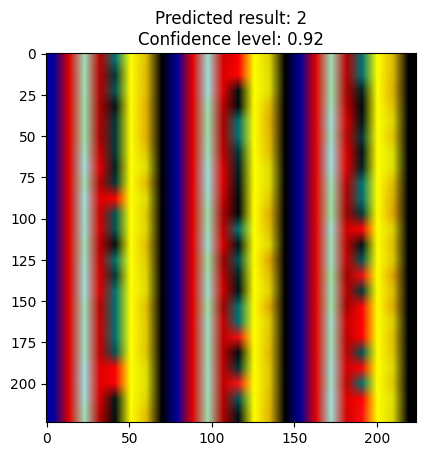

In [96]:
import cv2
import matplotlib.pyplot as plt

test = cv2.imread(test_images[0])
img_show = test[:, :, [2, 1, 0]]
test = test / 255.
test_shape = (1,) + test.shape
test = test.reshape(test_shape)

res = vgg16_model.predict(test)

prob = res[0, np.argmax(res, axis=1)[0]]
res = label[np.argmax(res, axis=1)[0]]
print('Predicted result for the first image: %s' % res)
print('Confidence level: %s' % prob)

# Save the image with the prediction and confidence level
plt.imshow(img_show)
plt.title('Predicted result: ' + res + '\n' + 'Confidence level: {:.2f}'.format(prob))
plt.savefig('predicted_image2.png')  # Save the figure as a PNG image
plt.show()

1/1 [==============================] - 18s 18s/step
Predicted result for the first image: 0
Confidence level: 0.9999999


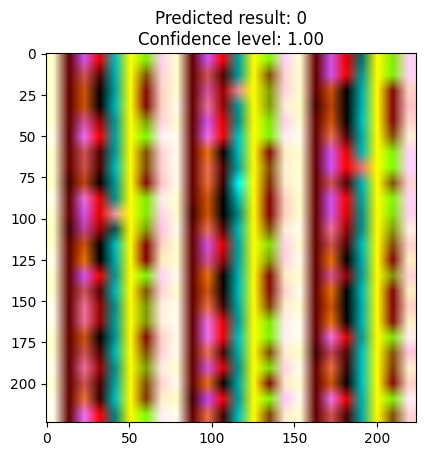

In [95]:
import cv2
import matplotlib.pyplot as plt

test = cv2.imread(test_images[700])
img_show = test[:, :, [2, 1, 0]]
test = test / 255.
test_shape = (1,) + test.shape
test = test.reshape(test_shape)

res = vgg16_model.predict(test)

prob = res[0, np.argmax(res, axis=1)[0]]
res = label[np.argmax(res, axis=1)[0]]
print('Predicted result for the first image: %s' % res)
print('Confidence level: %s' % prob)

# Save the image with the prediction and confidence level
plt.imshow(img_show)
plt.title('Predicted result: ' + res + '\n' + 'Confidence level: {:.2f}'.format(prob))
plt.savefig('predicted_image1.png')  # Save the figure as a PNG image
plt.show()

1/1 [==============================] - 0s 22ms/step
Predicted result for the first image: 1
Confidence level: 0.99218106


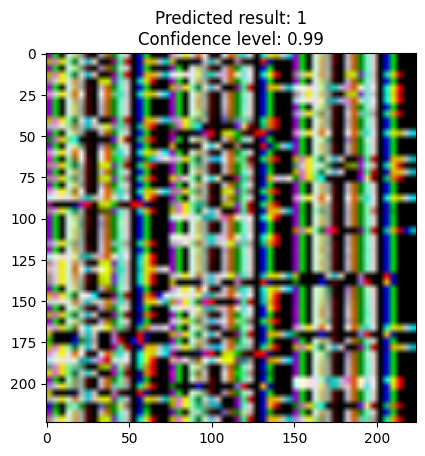

In [94]:
import cv2
import matplotlib.pyplot as plt

test = cv2.imread(test_images[1000])
img_show = test[:, :, [2, 1, 0]]
test = test / 255.
test_shape = (1,) + test.shape
test = test.reshape(test_shape)

res = vgg16_model.predict(test)

prob = res[0, np.argmax(res, axis=1)[0]]
res = label[np.argmax(res, axis=1)[0]]
print('Predicted result for the first image: %s' % res)
print('Confidence level: %s' % prob)

# Save the image with the prediction and confidence level
plt.imshow(img_show)
plt.title('Predicted result: ' + res + '\n' + 'Confidence level: {:.2f}'.format(prob))
plt.savefig('predicted_image.png')  # Save the figure as a PNG image
plt.show()


In [142]:
%%time
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    my_model_model_batch=my_model_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=my_model_model_batch[0,np.argmax(my_model_model_batch,axis=1)[0]]
    res=label[np.argmax(my_model_model_batch,axis=1)[0]]
    predict.append(res)

# Disable progress bar
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

1/1 [==============================] - 0s 21ms/step
CPU times: user 52.9 s, sys: 3.1 s, total: 56 s
Wall time: 54.1 s


In [79]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('Xception accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

Xception accuracy: 0.994140625
precision: 0.9944691880841121
recall: 0.994140625
f1: 0.9941974966550253
[[315   6   0   0   0]
 [  0 101   0   0   0]
 [  0   0 200   0   0]
 [  0   0   0 181   0]
 [  0   0   0   0 221]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       321
           1       0.94      1.00      0.97       101
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       181
           4       1.00      1.00      1.00       221

    accuracy                           0.99      1024
   macro avg       0.99      1.00      0.99      1024
weighted avg       0.99      0.99      0.99      1024



#resnet

In [148]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    resnet_model_batch=resnet_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=resnet_model_batch[0,np.argmax(resnet_model_batch,axis=1)[0]]
    res=label[np.argmax(resnet_model_batch,axis=1)[0]]
    predict.append(res)
    

1/1 [==============================] - 0s 22ms/step
CPU times: user 1min 5s, sys: 3.65 s, total: 1min 8s
Wall time: 1min 2s


In [149]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('inception accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

inception accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
[[321   0   0   0   0]
 [  0 101   0   0   0]
 [  0   0 200   0   0]
 [  0   0   0 181   0]
 [  0   0   0   0 221]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       321
           1       1.00      1.00      1.00       101
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       181
           4       1.00      1.00      1.00       221

    accuracy                           1.00      1024
   macro avg       1.00      1.00      1.00      1024
weighted avg       1.00      1.00      1.00      1024



In [ ]:
#inception

In [80]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    inception_model_batch=inception_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=inception_model_batch[0,np.argmax(inception_model_batch,axis=1)[0]]
    res=label[np.argmax(inception_model_batch,axis=1)[0]]
    predict.append(res)
    

1/1 [==============================] - 0s 29ms/step
CPU times: user 1min 10s, sys: 3.16 s, total: 1min 13s
Wall time: 1min 10s


In [81]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('inception accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

inception accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
[[321   0   0   0   0]
 [  0 101   0   0   0]
 [  0   0 200   0   0]
 [  0   0   0 181   0]
 [  0   0   0   0 221]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       321
           1       1.00      1.00      1.00       101
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       181
           4       1.00      1.00      1.00       221

    accuracy                           1.00      1024
   macro avg       1.00      1.00      1.00      1024
weighted avg       1.00      1.00      1.00      1024



In [ ]:
#Average

In [87]:
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout,Average
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD
import operator
import numpy as np
from PIL import Image
from collections import defaultdict
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [150]:
import time
t1 = time.time()
img=Input(shape=(224,224,3),name='img')
feature1=inception_model(img)
feature2=vgg16_model(img)
feature3=resnet_model(img)
for layer in inception_model.layers:  
    layer.trainable = False 
for layer in vgg16_model.layers:  
    layer.trainable = False  
for layer in resnet_model.layers:  
    layer.trainable = False  
output=Average()([feature1,feature2,feature3]) #add the confidence lists generated by 3 models
model=Model(inputs=img,outputs=output)

#the optimization function
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

The testing time is :1.396176 seconds


In [151]:
#read images from validation folder
rootdir = './dataset/test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

4 ./dataset/test_224/4/24381.png


In [152]:
#test the averaging model on the validation set
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range((length//127)+1):
    inputimg=test_images[127*i:127*(i+1)]
    test_batch=[]
    for path in inputimg:
        thisimg=np.array(Image.open(path))/255
        test_batch.append(thisimg)
    #print(i, np.array(test_batch).shape)
    model_batch=model.predict(np.array(test_batch))
    predict_batch=list(np.argmax(model_batch,axis=1))
    predict_batch=[label[con] for con in predict_batch]
    predict.append(predict_batch)

predict=sum(predict,[])

t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

1/1 [==============================] - 0s 130ms/step
The testing time is :6.610775 seconds


In [153]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(test_laels,predict)
print('Probability Averaging accuracy:%s'%acc)

Probability Averaging accuracy:1.0


In [154]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

[[321   0   0   0   0]
 [  0 101   0   0   0]
 [  0   0 200   0   0]
 [  0   0   0 181   0]
 [  0   0   0   0 221]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       321
           1       1.00      1.00      1.00       101
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       181
           4       1.00      1.00      1.00       221

    accuracy                           1.00      1024
   macro avg       1.00      1.00      1.00      1024
weighted avg       1.00      1.00      1.00      1024



In [155]:
!pip install seaborn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


inception accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
Confusion Matrix:
[[321   0   0   0   0]
 [  0 101   0   0   0]
 [  0   0 200   0   0]
 [  0   0   0 181   0]
 [  0   0   0   0 221]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       321
     Class 1       1.00      1.00      1.00       101
     Class 2       1.00      1.00      1.00       200
     Class 3       1.00      1.00      1.00       181
     Class 4       1.00      1.00      1.00       221

    accuracy                           1.00      1024
   macro avg       1.00      1.00      1.00      1024
weighted avg       1.00      1.00      1.00      1024



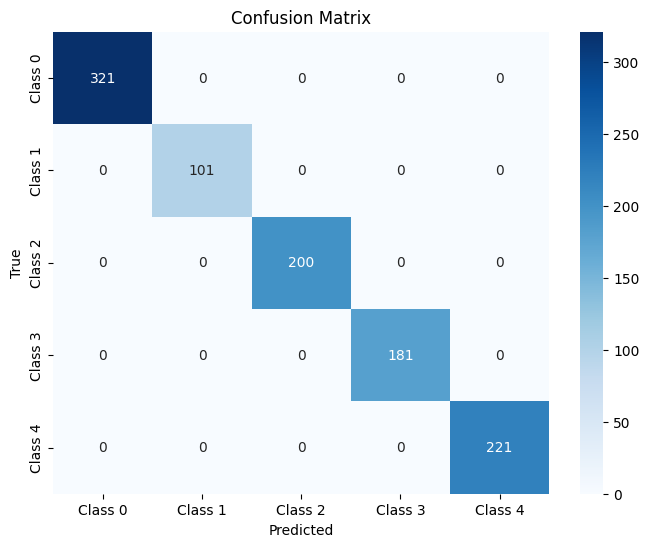

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Assuming 'test_labels' contains the true labels for the test data
# and 'predict' contains the predicted labels

acc = accuracy_score(test_laels, predict)
pre = precision_score(test_laels, predict, average='weighted')
re = recall_score(test_laels, predict, average='weighted')
f1 = f1_score(test_laels, predict, average='weighted')

print('inception accuracy: %s' % acc)
print('precision: %s' % pre)
print('recall: %s' % re)
print('f1: %s' % f1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_laels, predict)

print('Confusion Matrix:')
print(conf_matrix)

target_names = ['Normal', 'Botnet', 'Class 2', 'Class 3', 'Class 4']

# Generate classification report
class_report = classification_report(test_laels, predict, target_names=target_names)

print('Classification Report:')
print(class_report)

# Beautify the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()
